<a href="https://colab.research.google.com/github/sonsm0318/20240616/blob/main/YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16605, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 16605 (delta 50), reused 94 (delta 45), pack-reused 16459
Receiving objects: 100% (16605/16605), 15.34 MiB | 18.39 MiB/s, done.
Resolving deltas: 100% (11353/11353), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [4]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.1 MB/s eta 0:00:00
Setup complete. Using torch 2.3.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [5]:
!pip install -q roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="289xxPyAuzK17lsPnAVe")
project = rf.workspace("sangmin-son").project("abcd_assignment-axcnp")
version = project.version(1).download("yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ABCD_Assignment-1 in yolov5pytorch:: 100%|██████████| 1086/1086 [00:00<00:00, 6388.34it/s]


In [6]:
%cd /content/yolov5

/content/yolov5


In [7]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /content/yolov5/ABCD_Assignment-1/data.yaml

names:
- ball
- goal
- soccoer_player
nc: 3
roboflow:
  license: CC BY 4.0
  project: abcd_assignment-axcnp
  url: https://universe.roboflow.com/sangmin-son/abcd_assignment-axcnp/dataset/1
  version: 1
  workspace: sangmin-son
test: ../test/images
train: ABCD_Assignment-1/train/images
val: ABCD_Assignment-1/valid/images


In [8]:
# define number of classes based on YAML
import yaml

file_path = '/content/yolov5/ABCD_Assignment-1'

with open(file_path + "/data.yaml" , 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [10]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)

In [14]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 10 --data /content/yolov5/ABCD_Assignment-1/data.yaml --cfg /content/yolov5/models/yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-06-15 22:08:59.145004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 22:08:59.145067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 22:08:59.146329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 22:08:59.153381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 22:09:00.448854: W

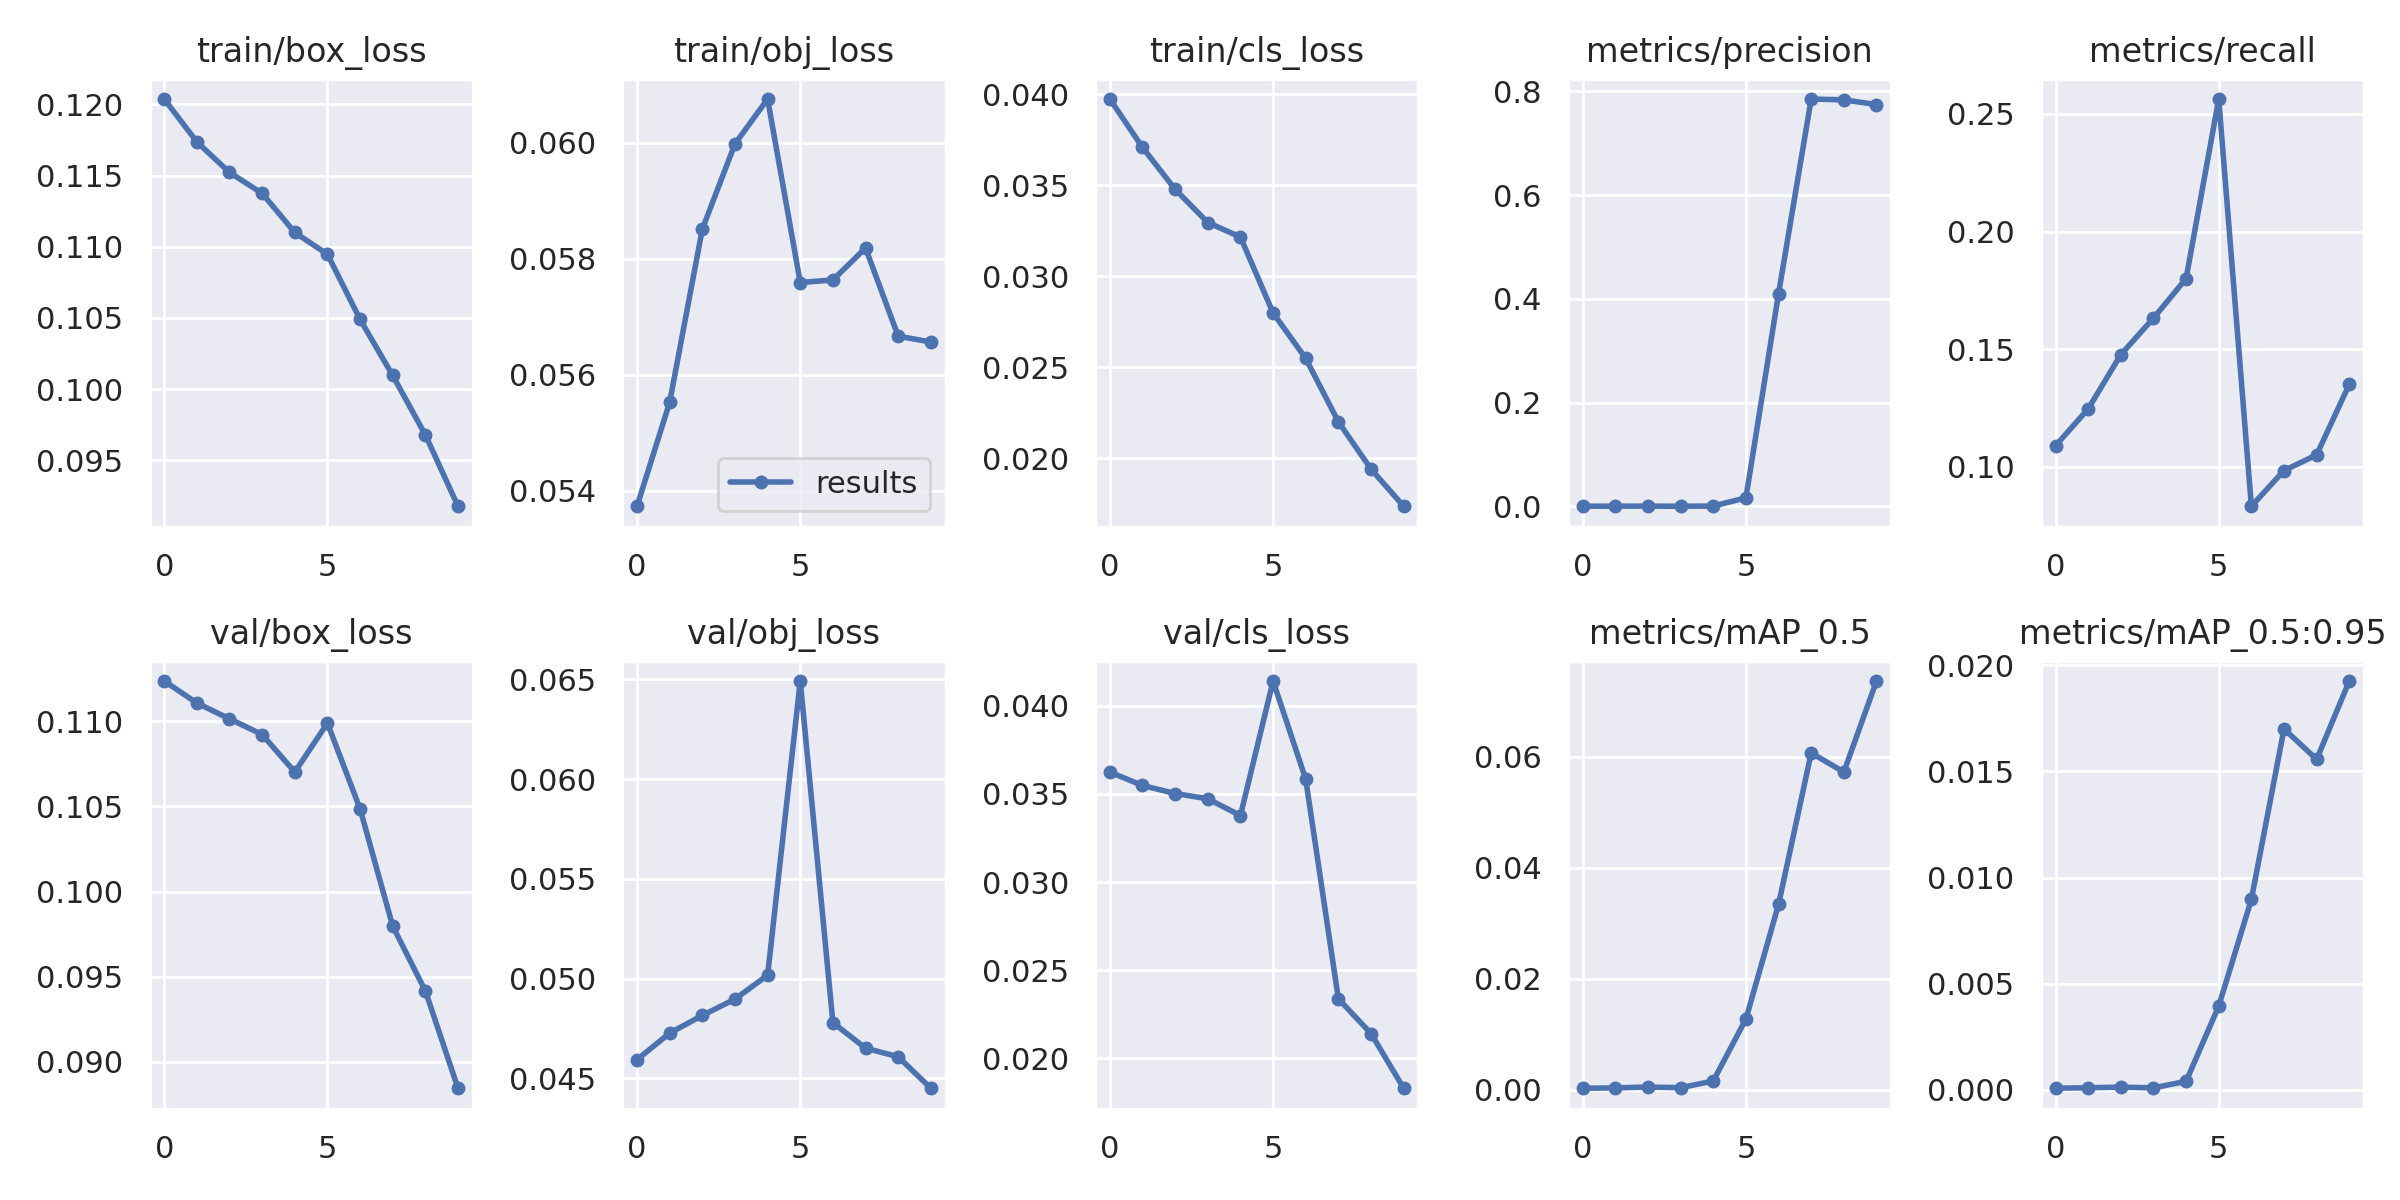

In [16]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

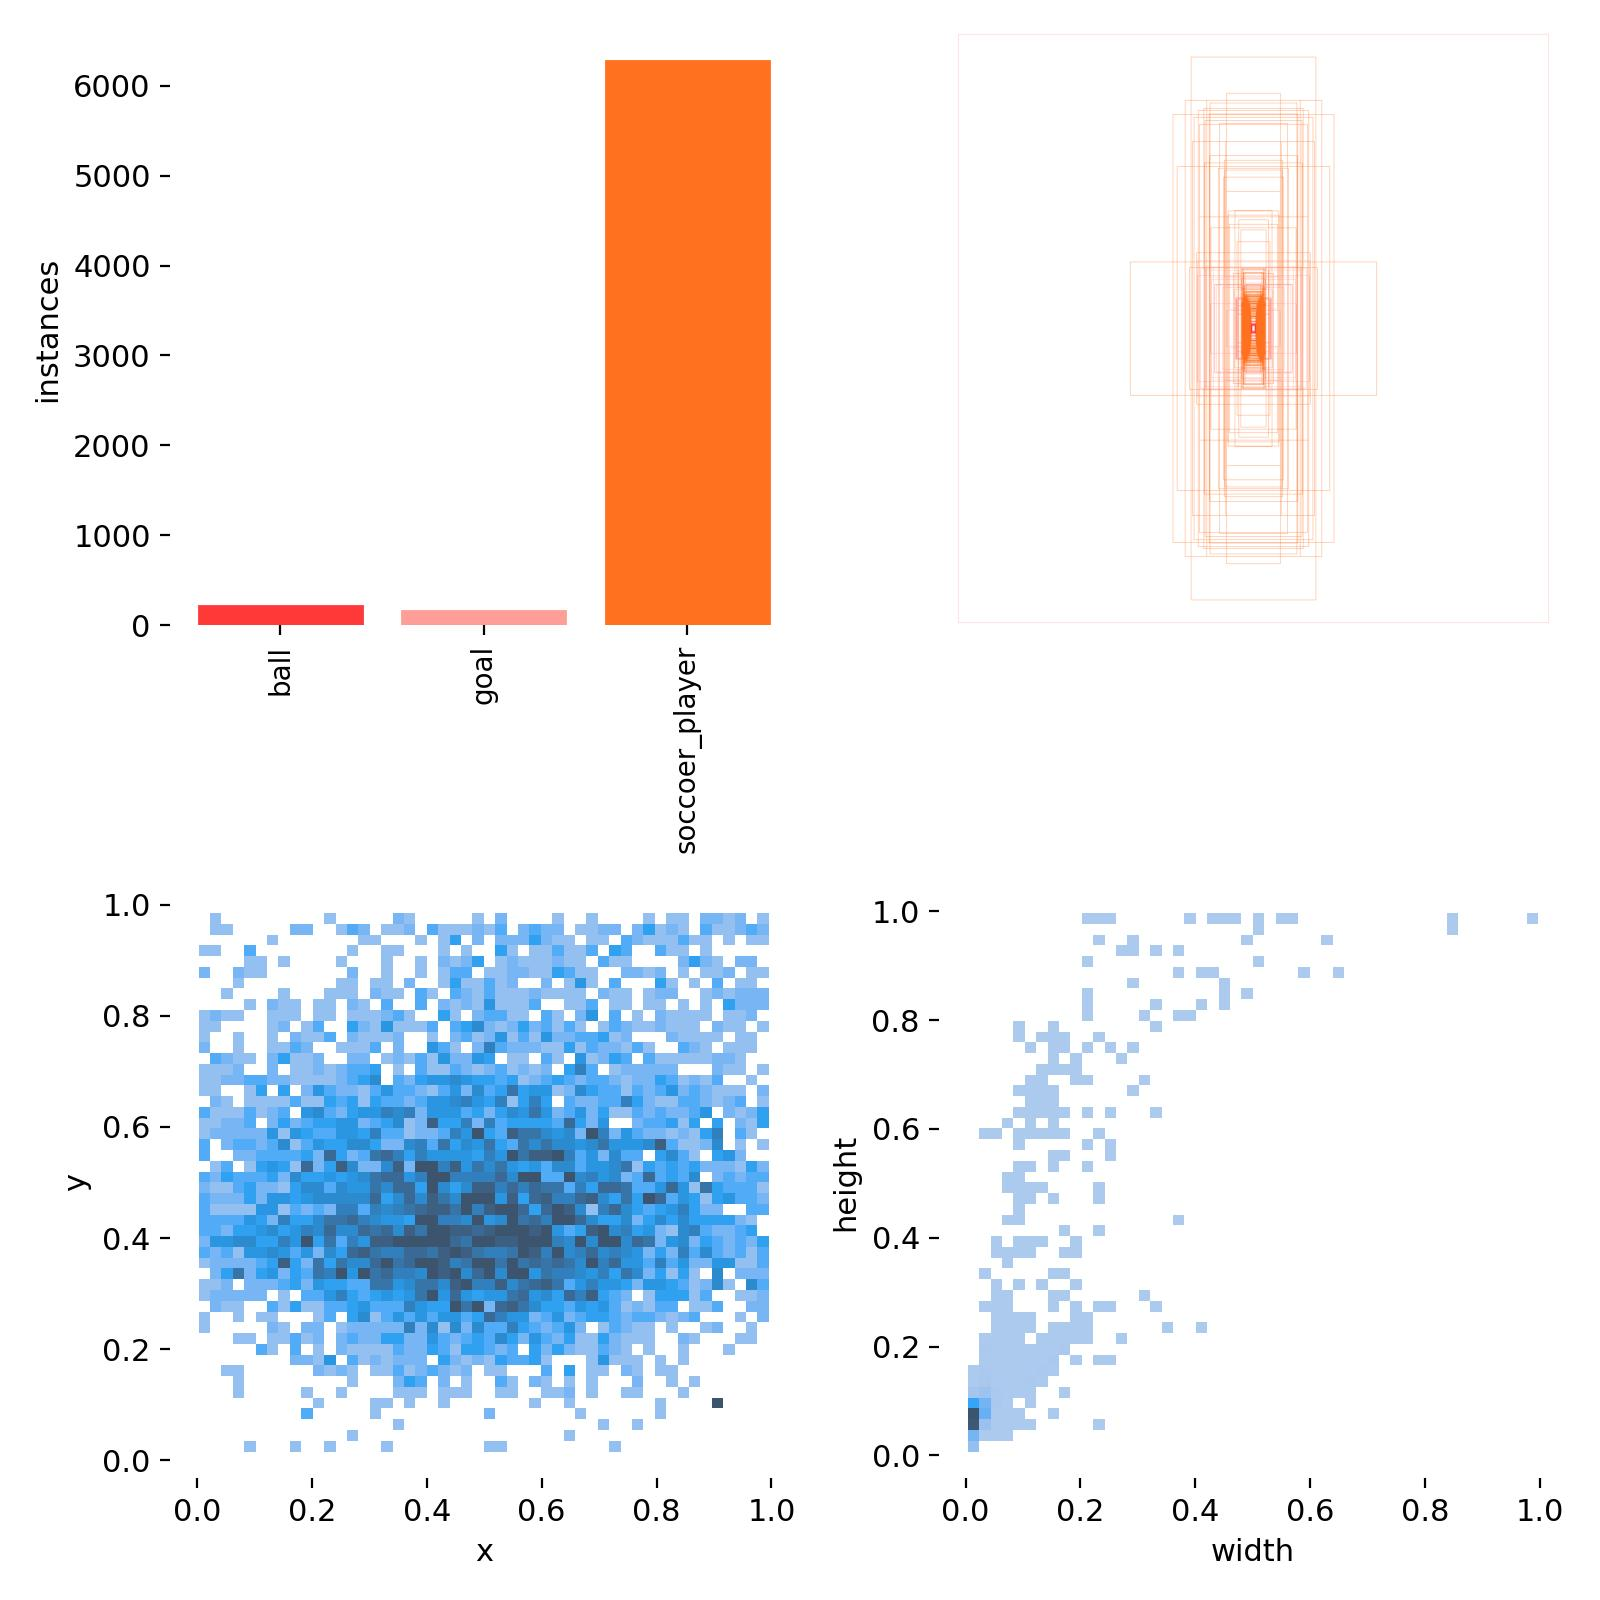

In [17]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


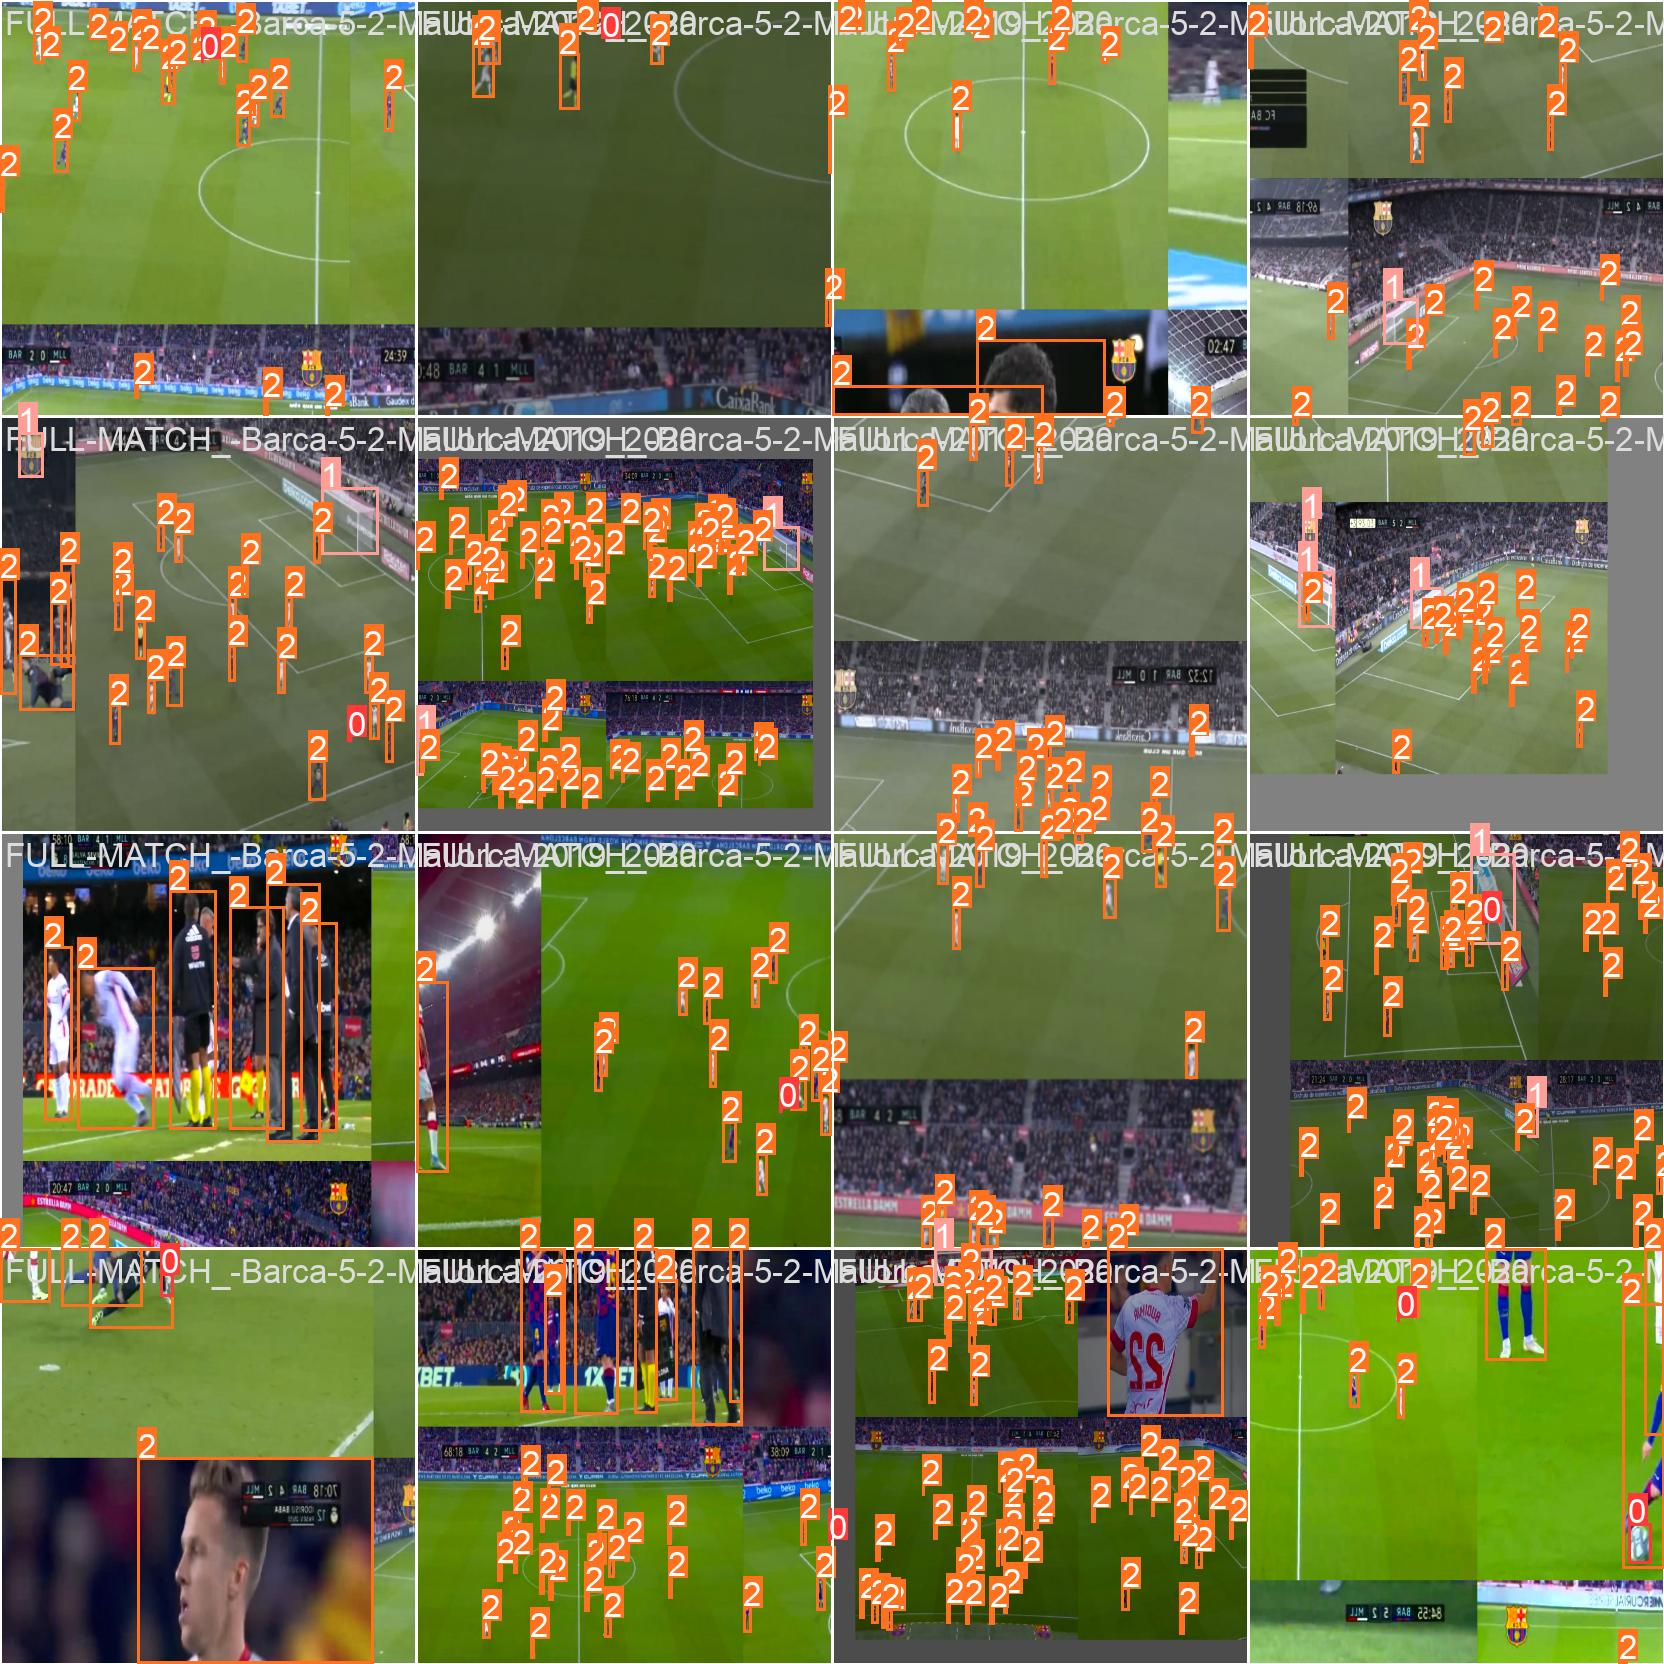

In [19]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

In [20]:
%ls runs/

train/


In [21]:
%ls runs/train/yolov5s_results/weights

In [24]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/ABCD_Assignment-1/test/images


/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/ABCD_Assignment-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/54 /content/yolov5/ABCD_Assignment-1/test/images/FULL-MATCH_-Barca-5-2-Mallorca-2019_2020-_mp4-0010_jpg.rf.69a5adaff9df8800266bc16e570936a7.jpg: 416x416 (no detections), 7.1ms
image 2/54 /content/yolov5/ABCD_Assignment-1/test/images/FULL-MATCH_-Barca-5-2-Mallorca-20

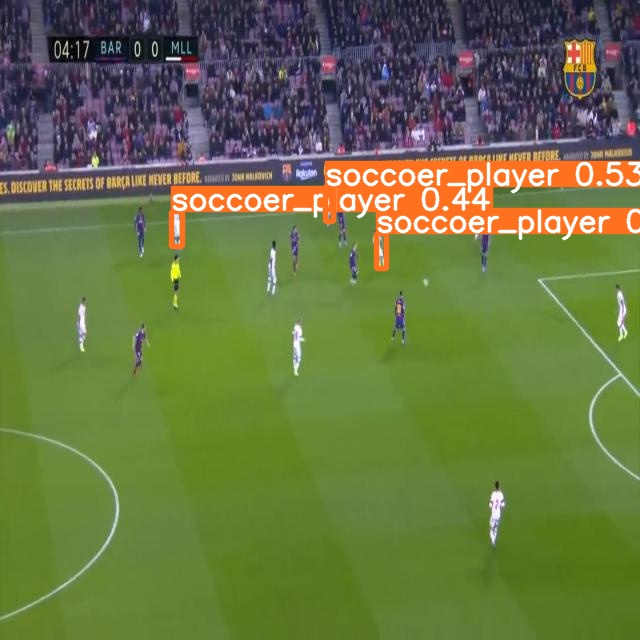

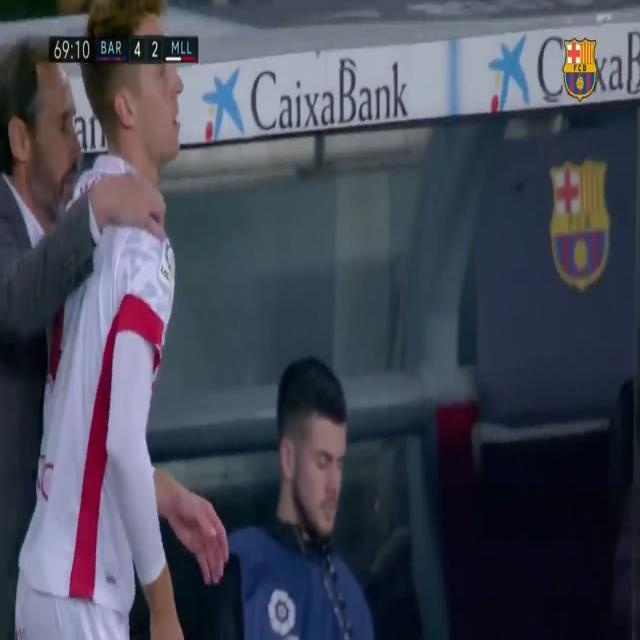

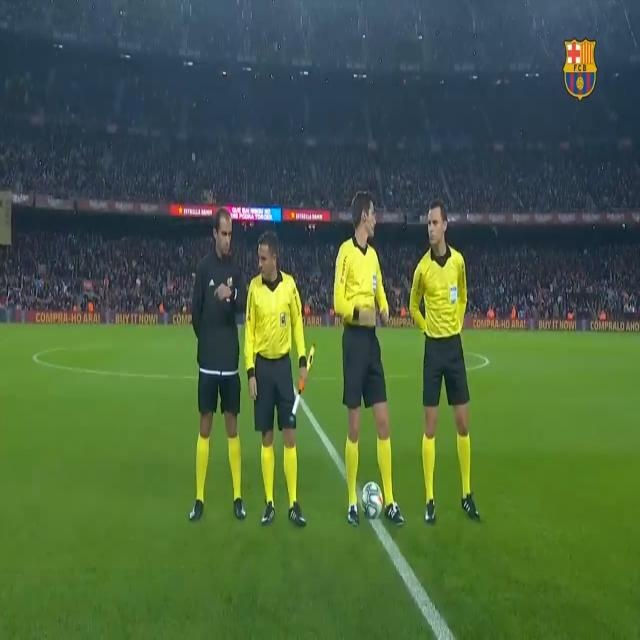

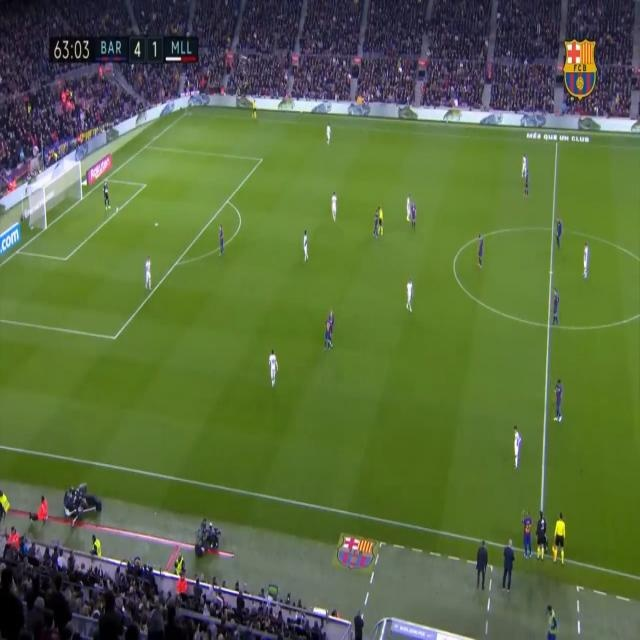

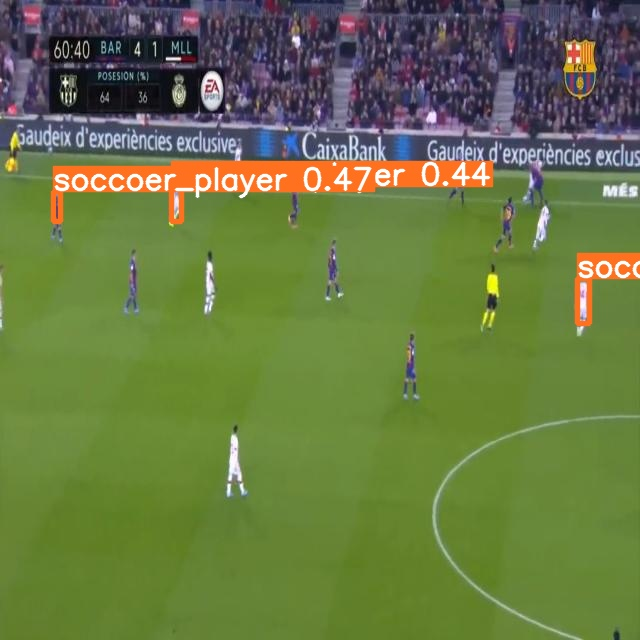

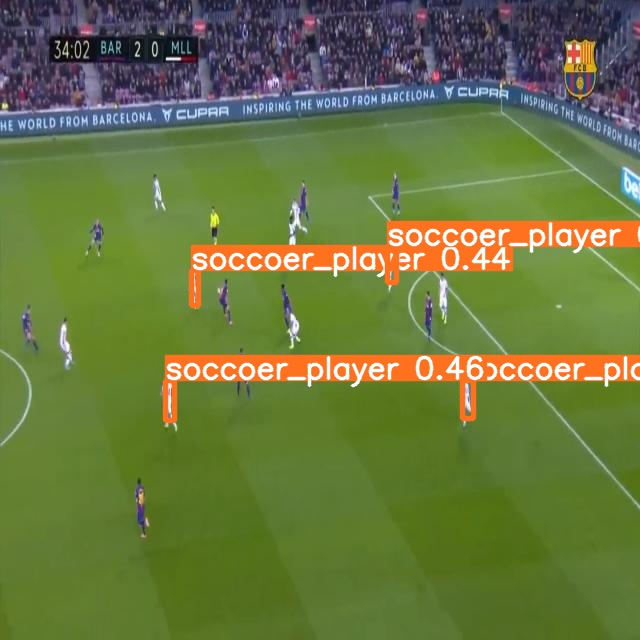

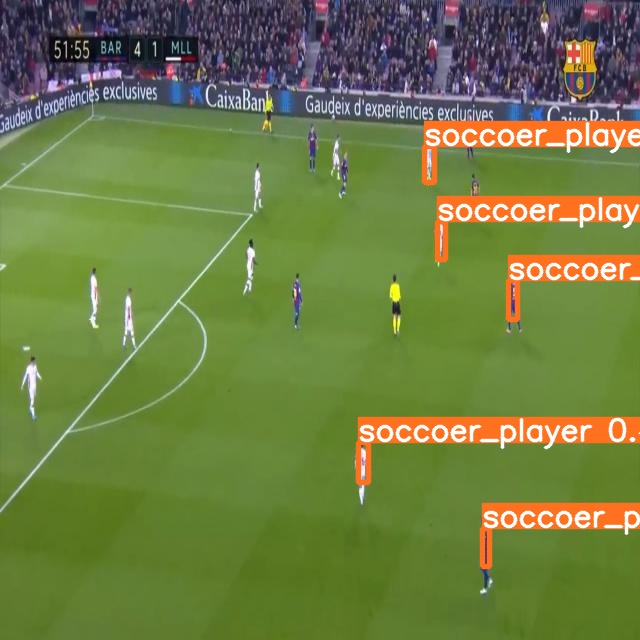

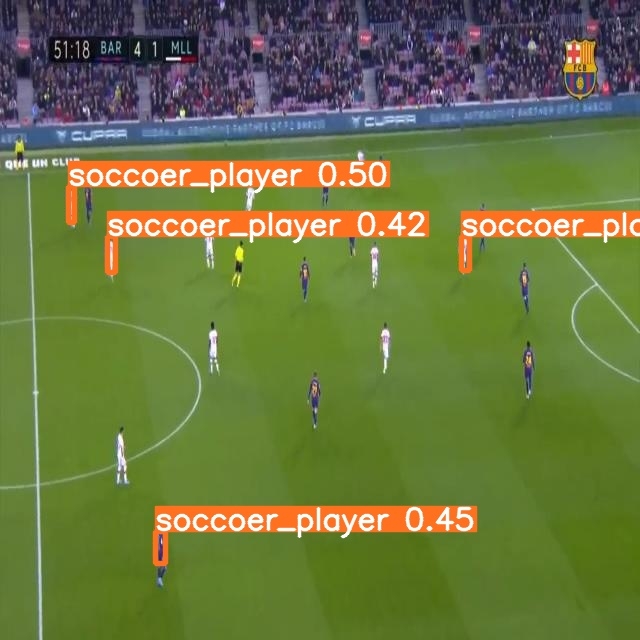

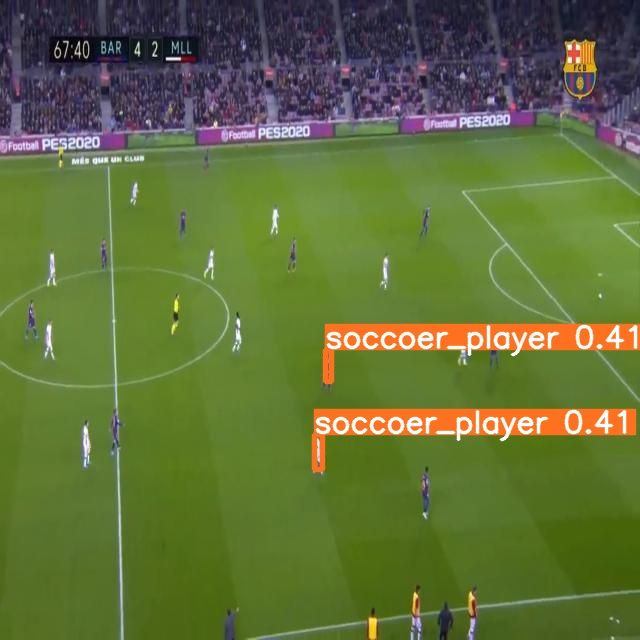

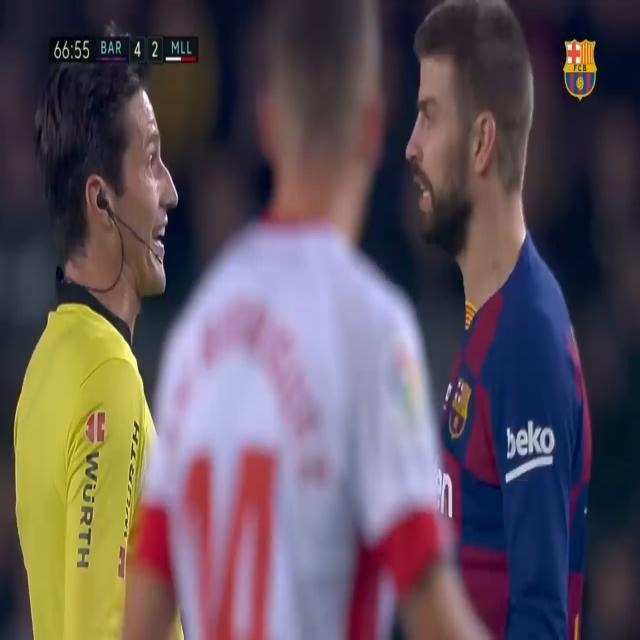

In [25]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

In [27]:
rf = Roboflow(api_key="289xxPyAuzK17lsPnAVe")
project = rf.workspace("sangmin-son").project("abcd_assignment-axcnp")
dataset = project.version(1)

project.version(dataset.version).deploy(model_type="yolov5", model_path=f"/content/yolov5/runs/train/yolov5s_results2")


loading Roboflow workspace...
loading Roboflow project...
An error occured when getting the model upload URL: This version already has a trained model. Please generate and train a new version in order to upload model to Roboflow.


In [30]:
#Run inference on your model on a persistant, auto-scaling, cloud API

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = "/content/yolov5/ABCD_Assignment-1/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

running inference on FULL-MATCH_-Barca-5-2-Mallorca-2019_2020-_mp4-0772_jpg.rf.f35a877a6b4f27c608fb45d1b6279de5.jpg


{'predictions': [{'x': 622.5,
   'y': 494.0,
   'width': 23.0,
   'height': 60.0,
   'confidence': 0.9117423295974731,
   'class': 'soccoer_player',
   'class_id': 2,
   'detection_id': 'cd3ce3c9-175d-4d22-96a1-7a45ab6f7b57',
   'image_path': '/content/yolov5/ABCD_Assignment-1/test/images/FULL-MATCH_-Barca-5-2-Mallorca-2019_2020-_mp4-0772_jpg.rf.f35a877a6b4f27c608fb45d1b6279de5.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 352.5,
   'y': 456.5,
   'width': 11.0,
   'height': 51.0,
   'confidence': 0.9070966839790344,
   'class': 'soccoer_player',
   'class_id': 2,
   'detection_id': '0a4c8624-dcac-4064-abec-7aa1a8fa4b87',
   'image_path': '/content/yolov5/ABCD_Assignment-1/test/images/FULL-MATCH_-Barca-5-2-Mallorca-2019_2020-_mp4-0772_jpg.rf.f35a877a6b4f27c608fb45d1b6279de5.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 263.5,
   'y': 426.5,
   'width': 11.0,
   'height': 55.0,
   'confidence': 0.9024508595466614,
   'class': 'soccoer_player',
   'class_id'